# Galaxy data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import healpy as hp

gal_small_fiducial_df = pd.read_parquet("./data/small_fiducial.parquet")
print('-------columns--------')
print(gal_small_fiducial_df.columns)
print('catalog num: ' + str(len(gal_small_fiducial_df)))

-------columns--------
Index(['mag_true_g_lsst_no_host_extinction', 'dec_true',
       'mag_true_i_lsst_no_host_extinction',
       'Mag_true_g_lsst_z0_no_host_extinction',
       'Mag_true_r_lsst_z0_no_host_extinction',
       'Mag_true_i_lsst_z0_no_host_extinction',
       'mag_true_r_lsst_no_host_extinction', 'galaxyID',
       'mag_true_z_lsst_no_host_extinction',
       'Mag_true_z_lsst_z0_no_host_extinction',
       'Mag_true_u_lsst_z0_no_host_extinction',
       'mag_true_Y_lsst_no_host_extinction',
       'mag_true_u_lsst_no_host_extinction', 'is_central', 'redshift_true',
       'Mag_true_Y_lsst_z0_no_host_extinction', 'ra_true', 'hp_ind_nside128',
       'redshift_measured'],
      dtype='object')
catalog num: 2407311


# Generate GW data

/Users/hayato/research/env/lib/python3.10/site-packages/lalsimulation/lalsimulation.py:8: UserWarning: Wswiglal-redir-stdio:

SWIGLAL standard output/error redirection is enabled in IPython.
This may lead to performance penalties. To disable locally, use:

with lal.no_swig_redirect_standard_output_error():
    ...

To disable globally, use:

lal.swig_redirect_standard_output_error(False)

Note however that this will likely lead to error messages from
LAL functions being either misdirected or lost when called from
Jupyter notebooks.

To suppress this warning, use:

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal

  import lal


Cosmological parameters used in the simulation:
H0: 71.0 km/s/Mpc
Omega_m: 0.2647887323943662
Omega_lambda: 0.7352112676056338
random seed for galaxy sampling: 41


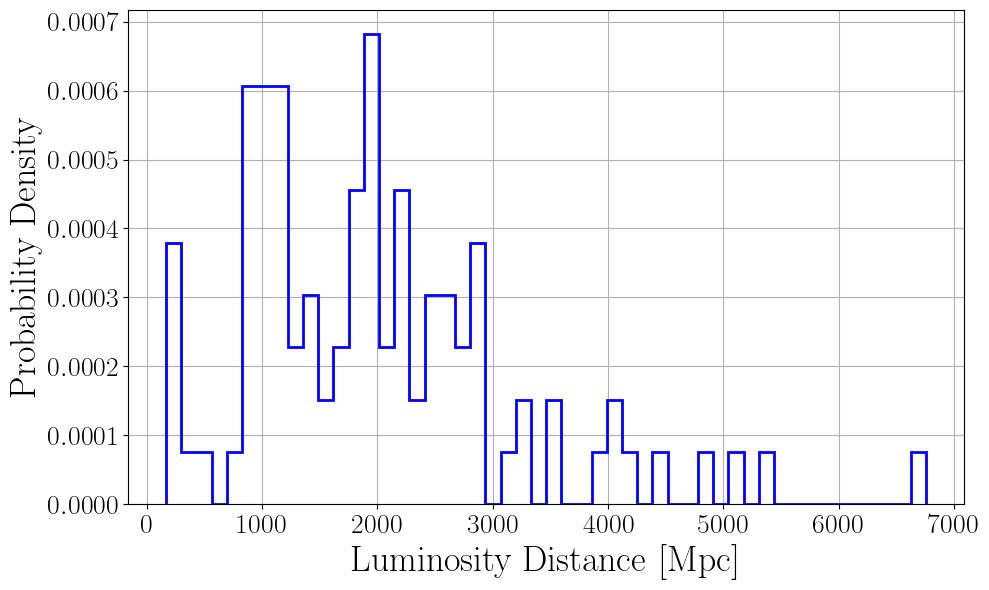

random seed for param sampling: 42


100%|██████████| 100/100 [00:11<00:00,  8.98it/s]


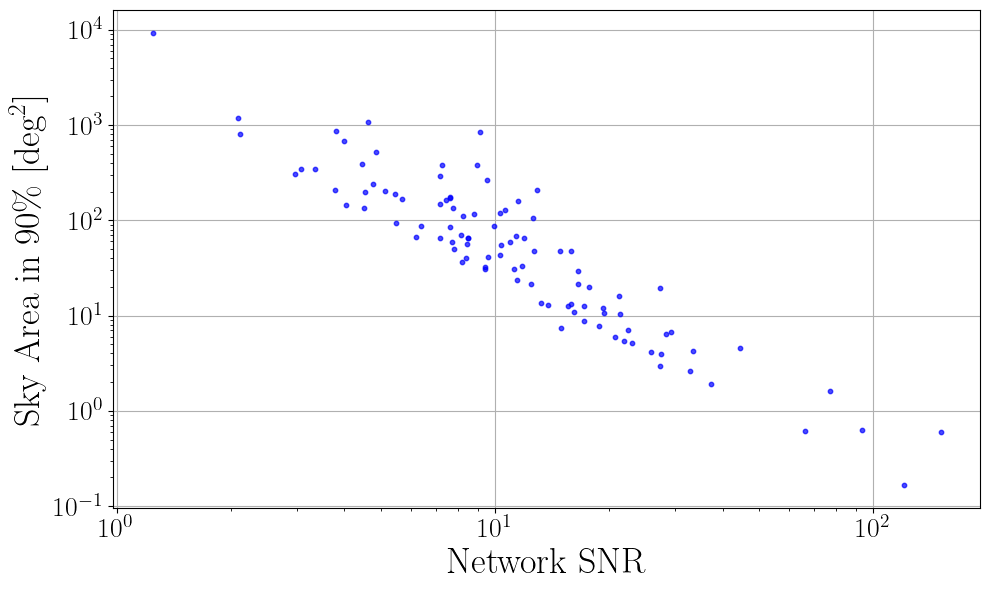

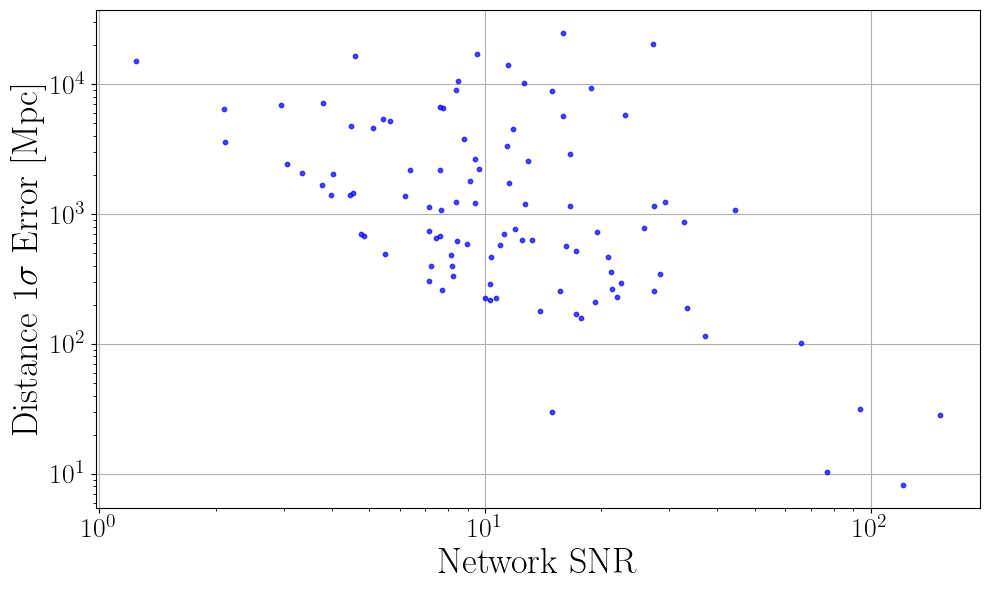

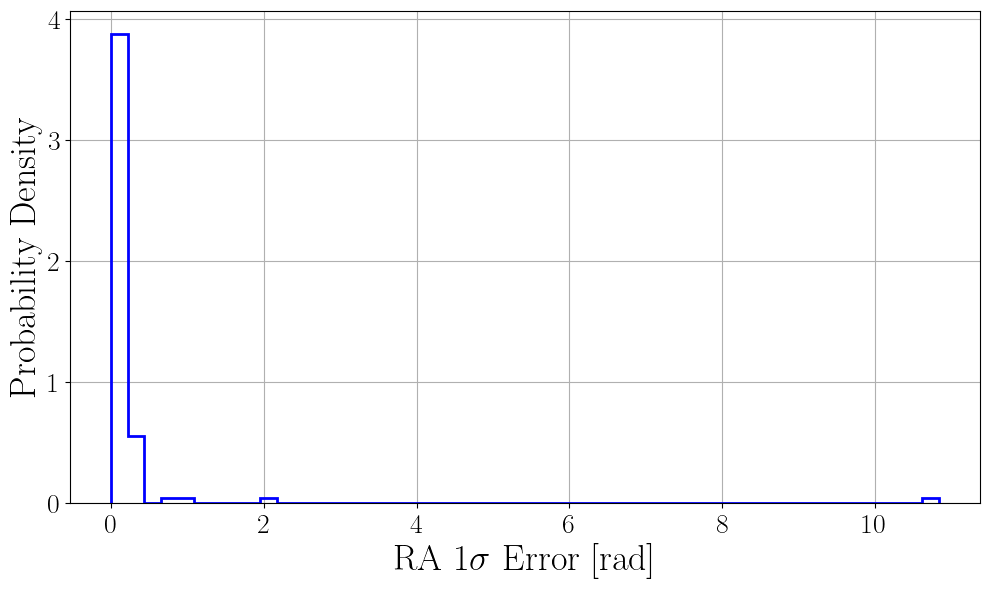

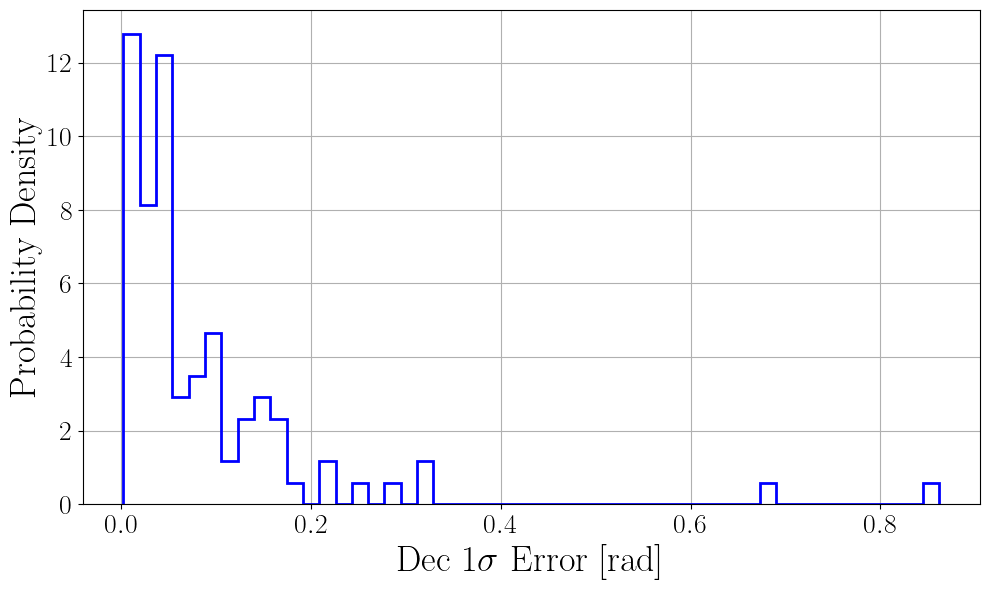

ramdom seed for distance measurement error: 43
Resampling 10 negative distance values...
Resampling 5 negative distance values...
Resampling 2 negative distance values...
Resampling 1 negative distance values...
Resampling 1 negative distance values...
Resampling 1 negative distance values...
Resampling 1 negative distance values...
Resampling 1 negative distance values...
Number of detected events (SNR >= 8.0): 67 out of 100 samples.


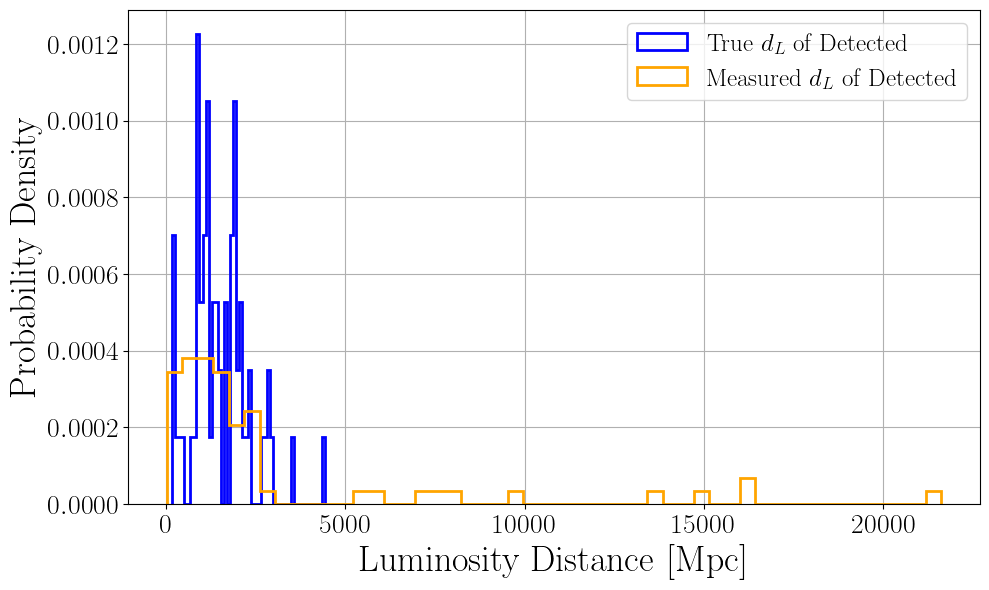

Sky area (90% C.I.) closest to 10.0 deg^2: 10.39603463459483 deg^2
  Corresponding SNR: 21.35455312065382
  Corresponding dL error: 264.6118776033731
  Corresponding true and measured dL: 973.5358462781894, 914.3336802094246
Injection parameters of the event chosen here:
  mass_1: 30.0
  mass_2: 30.0
  chi_1: 0.0
  chi_2: 0.0
  luminosity_distance: 973.5358462781894
  geocent_time: 1187008882.4
  ra: 62.3914980559008
  dec: -36.66813520042837
  theta_jn: 1.900574358971273
  psi: 3.117639781639845
  phase: 3.1700318395446816


In [2]:
from astropy.cosmology import FlatLambdaCDM
from scipy.stats import norm
from scipy.interpolate import interp1d
import bilby
from GWFish.modules.detection import Network
from GWFish.modules.fishermatrix import compute_network_errors
import GWFish.modules.waveforms as wf
from run_fisher_analysis import fisher_analysis_GWfish

"""cosmological parameters used in the simulation"""
h = 0.71
omega_cdm = 0.1109
omega_b = 0.02258
n_s = 0.963
sigma_8 = 0.8
w = -1.0

omega_m = (omega_cdm + omega_b) / (h ** 2)
omega_lambda = 1.0 - omega_m
true_H0 = h * 100.0  # in unit of km/s/Mpc
print("Cosmological parameters used in the simulation:")
print(f"H0: {true_H0} km/s/Mpc")
print(f"Omega_m: {omega_m}")
print(f"Omega_lambda: {omega_lambda}")

"""functions for cosmology calculations"""
def luminosity_distance(z, H0, Om=omega_m, Olamda=omega_lambda):
    H0 = H0
    Om = Om
    cosmo = FlatLambdaCDM(H0=H0, Om0=Om)
    return cosmo.luminosity_distance(z).value

def compute_network_SNR_and_sky_area(dL, ra, dec):
    random_seed = 42
    bilby.core.utils.random.seed(random_seed)
    print(f"random seed for param sampling: {random_seed}")
    theta_jn_sample = bilby.core.prior.Sine(name='theta_jn', boundary='reflective').sample(len(dL))
    psi_sample = bilby.core.prior.Uniform(name='psi', minimum=0, maximum=np.pi).sample(len(dL))
    phase_sample = bilby.core.prior.Uniform(name='phase', minimum=0, maximum=2 * np.pi).sample(len(dL))
    geocent_time = 1187008882.4  # time of GW170817
    
    param_dict = {
            'mass_1': 30.0 * np.ones_like(dL), # in source frame
            'mass_2': 30.0 * np.ones_like(dL), # in source frame
            'chi_1': 0.0 * np.ones_like(dL), 'chi_2': 0.0 * np.ones_like(dL),
            'luminosity_distance': dL,
            'geocent_time': geocent_time * np.ones_like(dL),
            'ra': ra,
            'dec': dec,
            'theta_jn': theta_jn_sample,
            'psi': psi_sample,
            'phase': phase_sample,
        }
    
    ### GWFish source code is modified by myself, but simpler calculation is working with the original code. ###
    ### For running the original code, see the documentation: https://gwfish.readthedocs.io/en/latest/tutorials/tutorial_170817.html ###
    params_df, network_snr, sky_area_deg2_90_list, ra_1sigma_error_list, dec_1sigma_error_list, corr_ra_dec_list, dL_1sigma_error_list = fisher_analysis_GWfish(param_dict)
    return params_df, network_snr, sky_area_deg2_90_list, ra_1sigma_error_list, dec_1sigma_error_list, corr_ra_dec_list, dL_1sigma_error_list

"""filter galaxy catalog by apparent magnitude"""
galcat_df = gal_small_fiducial_df.copy()

mag_cut_r = 21
mask = galcat_df['mag_true_r_lsst_no_host_extinction'] <= mag_cut_r
filtered_df = galcat_df.loc[mask]
true_redshifts_masked = galcat_df.loc[mask, 'redshift_true']
true_redshifts_range = [np.min(true_redshifts_masked), np.max(true_redshifts_masked)]
ra_masked = galcat_df.loc[mask, 'ra_true']
dec_masked = galcat_df.loc[mask, 'dec_true']

"""sample galaxies from the catalog according to weights"""
sample_size = 100
weights = np.ones_like(true_redshifts_masked) / len(true_redshifts_masked) # uniform weighting
# weights = 3.828e26 * 10**(-0.4 * galcat_df.loc[mask, 'Mag_true_r_lsst_z0_no_host_extinction']) / np.sum(3.828e26 * 10**(-0.4 * galcat_df.loc[mask, 'mag_true_r_lsst_no_host_extinction'])) # weighting by luminosity
gal_random_seed = 41
np.random.seed(gal_random_seed)
print(f'random seed for galaxy sampling: {gal_random_seed}')
sample_indices = np.random.choice(filtered_df.index, size=sample_size, replace=False, p=weights)
sample_ra = np.array(filtered_df.loc[sample_indices, 'ra_true'])
sample_dec = np.array(filtered_df.loc[sample_indices, 'dec_true'])
sampled_true_z = np.array(filtered_df.loc[sample_indices, 'redshift_true'])
sample_true_dL = luminosity_distance(sampled_true_z, true_H0)

plt.style.use('~/research/my_plot_style.style')
plt.figure()
plt.hist(sample_true_dL, bins=50, density=True, color='blue', histtype='step', lw=2)
plt.xlabel('Luminosity Distance [Mpc]')
plt.ylabel('Probability Density')
plt.grid(True)
plt.show()

"""compute network SNRs and sky localization areas"""
params_df, network_snr, sky_area_deg2_90_list, ra_1sigma_error_list, dec_1sigma_error_list, corr_ra_dec_list, dL_1sigma_error_list = compute_network_SNR_and_sky_area(sample_true_dL, sample_ra, sample_dec)

plt.figure()
plt.scatter(network_snr, sky_area_deg2_90_list, s=10, color='blue', alpha=0.7)
plt.xlabel('Network SNR')
plt.ylabel(r'Sky Area in $90\%$ [deg$^2$]')
plt.xscale('log')
plt.yscale('log')
plt.grid(True)
plt.show()

plt.figure()
plt.scatter(network_snr, dL_1sigma_error_list, s=10, color='blue', alpha=0.7)
plt.xlabel('Network SNR')
plt.ylabel(r'Distance $1\sigma$ Error [Mpc]')
plt.xscale('log')
plt.yscale('log')
plt.grid(True)
plt.show()

plt.figure()
plt.hist(ra_1sigma_error_list, bins=50, density=True, color='blue', histtype='step', lw=2)
plt.xlabel(r'RA $1\sigma$ Error [rad]')
plt.ylabel('Probability Density')
plt.grid(True)
plt.show()

plt.figure()
plt.hist(dec_1sigma_error_list, bins=50, density=True, color='blue', histtype='step', lw=2)
plt.xlabel(r'Dec $1\sigma$ Error [rad]')
plt.ylabel('Probability Density')
plt.grid(True)
plt.show()

dL_random_seed = 43
np.random.seed(dL_random_seed)
print(f'ramdom seed for distance measurement error: {dL_random_seed}')
measured_dL = np.random.normal(loc=sample_true_dL, scale=dL_1sigma_error_list)
negative_mask = measured_dL <= 0
while np.any(negative_mask):
    print(f"Resampling {np.sum(negative_mask)} negative distance values...")
    measured_dL[negative_mask] = np.random.normal(loc=sample_true_dL[negative_mask], scale=dL_1sigma_error_list[negative_mask])
    negative_mask = measured_dL <= 0

"""impose detection threshold"""
snr_threshold = 8.0
detected_mask = network_snr >= snr_threshold
detected_snr = network_snr[detected_mask]
print(f"Number of detected events (SNR >= {snr_threshold}): {len(detected_snr)} out of {sample_size} samples.")
detected_dL = measured_dL[detected_mask]
detected_true_z = sampled_true_z[detected_mask]

plt.figure()
plt.hist(sample_true_dL[detected_mask], bins=50, density=True, color='blue', histtype='step', lw=2, label=r'True $d_L$ of Detected')
plt.hist(detected_dL, bins=50, density=True, color='orange', histtype='step', lw=2, label=r'Measured $d_L$ of Detected')
plt.xlabel('Luminosity Distance [Mpc]')
plt.ylabel('Probability Density')
plt.grid(True)
plt.legend()
plt.show()

"""pick up good events"""
# best_index = np.argmax(network_snr)
# best_snr = np.max(network_snr)
# print(f"Largest detected SNR: {best_snr}")

# best_index = np.argmin(sky_area_deg2_90_list)
# best_localization = np.min(sky_area_deg2_90_list)
# print(f"Smallest sky area (90% C.I.): {best_localization} deg^2")

fiducial_localization = 10.0  # deg^2
best_index = np.argmin(np.abs(sky_area_deg2_90_list-fiducial_localization))
best_localization = sky_area_deg2_90_list[best_index]  # pick up closest to 10 deg^2
print(f"Sky area (90% C.I.) closest to {fiducial_localization} deg^2: {best_localization} deg^2")
print(f"  Corresponding SNR: {network_snr[best_index]}")
print(f"  Corresponding dL error: {dL_1sigma_error_list[best_index]}")
print(f"  Corresponding true and measured dL: {sample_true_dL[best_index]}, {measured_dL[best_index]}")

best_injection = params_df.iloc[best_index]
print("Injection parameters of the event chosen here:")
for key, value in best_injection.items():
    print(f"  {key}: {value}")


# Generate mock skymap

In [3]:
import numpy as np
import healpy as hp
from astropy.io import fits
from scipy.stats import multivariate_normal
from tqdm import tqdm


def create_fits_skymap_assuming_gaussian(ra_val, dec_val, ra_err, dec_err, corr, dL_val, dL_err, filename="../data/skymap.fits", nside=1024, be_nested=False):
    npix = hp.nside2npix(nside)
    
    theta, phi = hp.pix2ang(nside, np.arange(npix))
    ra_pix = phi
    dec_pix = 0.5 * np.pi - theta

    d_ra = (ra_pix - ra_val)
    d_ra = (d_ra + np.pi) % (2 * np.pi) - np.pi # -pi ~ pi に収める

    d_ra_scaled = d_ra * np.cos(dec_val)
    d_dec = dec_pix - dec_val

    sigma_x = ra_err * np.cos(dec_val) # RA方向の実距離成分
    sigma_y = dec_err
    cov = np.array([
        [sigma_x**2, corr * sigma_x * sigma_y],
        [corr * sigma_x * sigma_y, sigma_y**2]
    ])
    
    inv_cov = np.linalg.inv(cov)
    det_cov = np.linalg.det(cov)
    
    a = inv_cov[0, 0]
    b = inv_cov[0, 1]
    d = inv_cov[1, 1]
    
    exponent = -0.5 * (a * d_ra_scaled**2 + 2 * b * d_ra_scaled * d_dec + d * d_dec**2)
    prob = np.exp(exponent)
    
    prob_sum = np.sum(prob)
    if prob_sum > 0:
        prob /= prob_sum
    else:
        dist_ang = d_ra_scaled**2 + d_dec**2
        prob[np.argmin(dist_ang)] = 1.0

    distmu = np.ones(npix) * dL_val
    distsigma = np.ones(npix) * dL_err
    distnorm = np.ones(npix) / (distmu**2 + distsigma**2)

    col_prob = fits.Column(name='PROB', format='D', unit='pix-1', array=prob)
    col_distmu = fits.Column(name='DISTMU', format='D', unit='Mpc', array=distmu)
    col_distsigma = fits.Column(name='DISTSIGMA', format='D', unit='Mpc', array=distsigma)
    col_distnorm = fits.Column(name='DISTNORM', format='D', unit='Mpc-2', array=distnorm)

    cols = fits.ColDefs([col_prob, col_distmu, col_distsigma, col_distnorm])
    hdu = fits.BinTableHDU.from_columns(cols)

    hdu.header['PIXTYPE'] = 'HEALPIX'
    hdu.header['COORDSYS'] = 'C' # Celestial (Equatorial)
    hdu.header['NSIDE'] = nside
    hdu.header['INDXSCHM'] = 'IMPLICIT'
    hdu.header['OBJECT'] = 'MOCK_EVENT'
    
    if be_nested:
        # transform from RING to NESTED
        prob_nested = hp.reorder(prob, r2n=True)
        distmu_nested = hp.reorder(distmu, r2n=True)
        distsigma_nested = hp.reorder(distsigma, r2n=True)
        distnorm_nested = hp.reorder(distnorm, r2n=True)

        col_prob = fits.Column(name='PROB', format='D', unit='pix-1', array=prob_nested)
        col_distmu = fits.Column(name='DISTMU', format='D', unit='Mpc', array=distmu_nested)
        col_distsigma = fits.Column(name='DISTSIGMA', format='D', unit='Mpc', array=distsigma_nested)
        col_distnorm = fits.Column(name='DISTNORM', format='D', unit='Mpc-2', array=distnorm_nested)

        cols = fits.ColDefs([col_prob, col_distmu, col_distsigma, col_distnorm])
        hdu = fits.BinTableHDU.from_columns(cols)

        hdu.header['PIXTYPE'] = 'HEALPIX'
        hdu.header['ORDERING'] = 'NESTED'
        hdu.header['COORDSYS'] = 'C'
        hdu.header['NSIDE'] = nside
        hdu.header['INDXSCHM'] = 'IMPLICIT'
        hdu.header['OBJECT'] = 'MOCK_EVENT'

        print(f"Generated FITS file: {filename} (NESTED)")        
    else:
        hdu.header['ORDERING'] = 'RING'
        print(f"Generated FITS file: {filename} (RING)")

    primary_hdu = fits.PrimaryHDU()
    hdul = fits.HDUList([primary_hdu, hdu])
    hdul.writeto(filename, overwrite=True)
    

target_ra = best_injection['ra']
target_dec = best_injection['dec']
target_ra_rad = np.deg2rad(target_ra)
target_dec_rad = np.deg2rad(target_dec)
target_ra_err = ra_1sigma_error_list[best_index]
target_dec_err = dec_1sigma_error_list[best_index]
target_corr = corr_ra_dec_list[best_index]
target_dist = measured_dL[best_index]
target_dist_err = dL_1sigma_error_list[best_index]

GW_sky_map_file_path = "./data/gw_sim_skymap.fits"
create_fits_skymap_assuming_gaussian(
    ra_val=target_ra_rad,
    dec_val=target_dec_rad,
    ra_err=target_ra_err,
    dec_err=target_dec_err,
    corr=target_corr,
    dL_val=target_dist,
    dL_err=target_dist_err,
    filename=GW_sky_map_file_path,
    nside=1024,
    be_nested=False
)

Generated FITS file: ./data/gw_sim_skymap.fits (RING)


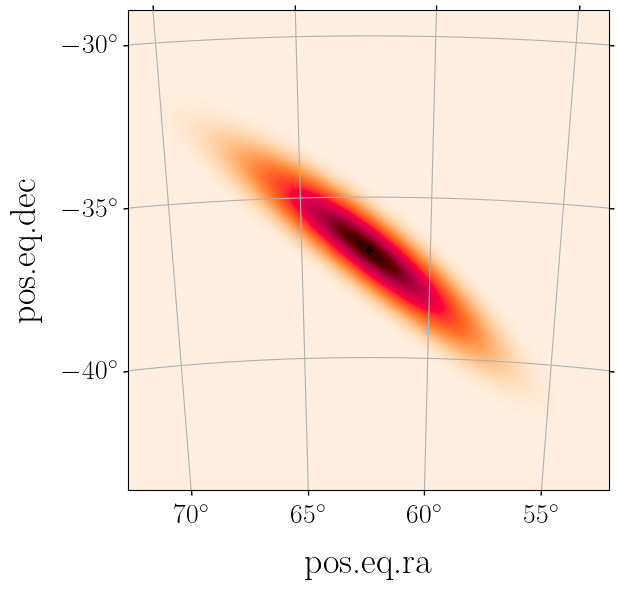

sum of PROB: 1.000000000000001


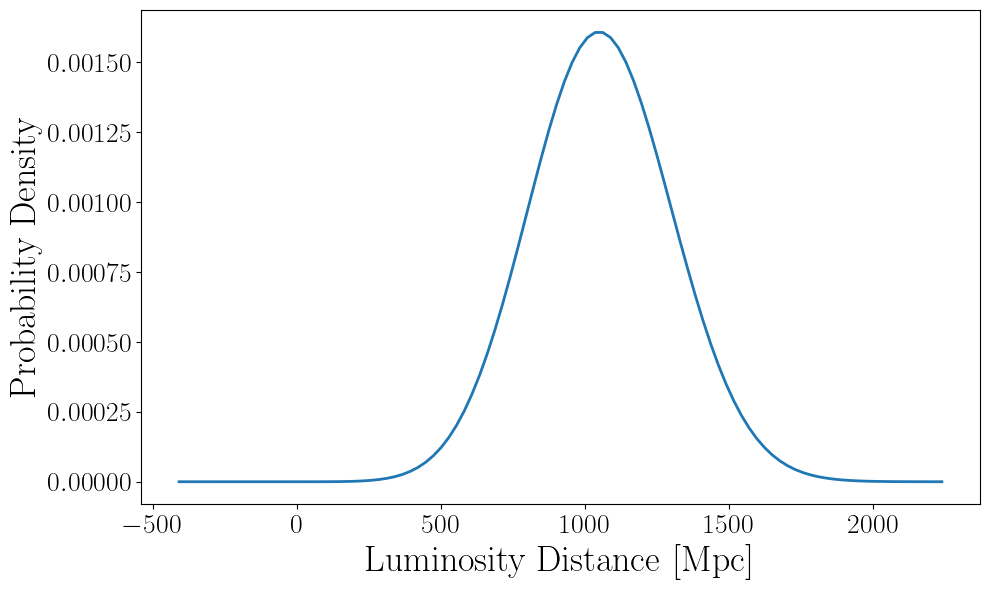

sum of p_dL: 0.9999982437093082


In [4]:
from astropy.coordinates import EarthLocation
from astropy.time import Time
from ligo.skymap.coordinates import DetectorFrame
from ligo.skymap.io import read_sky_map
import ligo.skymap.plot
from matplotlib import pyplot as plt
from ligo.skymap.postprocess import contour
import astropy.units as u
from astropy.coordinates import SkyCoord

"""import fits skymap"""
(prob, distmu, distsigma, distnorm), meta = read_sky_map(GW_sky_map_file_path, distances=True, moc=False)

npix = len(prob)
nside = hp.npix2nside(npix)
max_idx = np.argmax(prob)
theta, phi = hp.pix2ang(nside, max_idx)
ra_deg = np.rad2deg(phi)
dec_deg = np.rad2deg(0.5 * np.pi - theta)
plt.figure()
center_coord = SkyCoord(ra=ra_deg, dec=dec_deg, unit='deg')
ax = plt.axes(projection='astro zoom', center=center_coord, radius=target_dec_err*5 * u.rad) 
ax.imshow_hpx(prob, cmap='cylon')
ax.plot(ra_deg, dec_deg, transform=ax.get_transform('world'), marker='+', color='k')
ax.coords[0].set_format_unit(u.deg)
ax.coords[1].set_format_unit(u.deg)
ax.grid(True)
plt.show()
print(f'sum of PROB: {np.sum(prob)}')

dL_array = np.linspace(distmu[0]-5*distsigma[0], distmu[0]+5*distsigma[0], 100)
p_dL = []
plt.figure()
for rr in dL_array:
    p_dL.append(np.sum(prob * rr**2 * distnorm * norm(distmu, distsigma).pdf(rr)))
plt.plot(dL_array, p_dL)
plt.xlabel('Luminosity Distance [Mpc]')
plt.ylabel('Probability Density')
# plt.legend()
plt.grid()
plt.show()
print(f'sum of p_dL: {np.trapz(p_dL, dL_array)}')

# Compute likelihood

redshift array: 0.001 to 0.01915252251178938
calculating distance cut...
calculating sky position cut...
Number of galaxies after applying distance and sky position cuts: 4804 out of 211882


100%|██████████| 100/100 [00:34<00:00,  2.89it/s]
/var/folders/91/6k_wr_bj7r9cg9669rd966jc0000gn/T/ipykernel_6624/4136759608.py:191: RuntimeWarning: invalid value encountered in divide
  like /= np.trapz(like, h0_array)


Likelihood list: [<Quantity 0.>, <Quantity 0.>, <Quantity 0.>, <Quantity 0.>, <Quantity 0.>, <Quantity 0.>, <Quantity 0.>, <Quantity 0.>, <Quantity 0.>, <Quantity 0.>, <Quantity 0.>, <Quantity 0.>, <Quantity 0.>, <Quantity 0.>, <Quantity 0.>, <Quantity 0.>, <Quantity 0.>, <Quantity 0.>, <Quantity 0.>, <Quantity 0.>, <Quantity 0.>, <Quantity 0.>, <Quantity 0.>, <Quantity 0.>, <Quantity 0.>, <Quantity 0.>, <Quantity 0.>, <Quantity 0.>, <Quantity 0.>, <Quantity 0.>, <Quantity 0.>, <Quantity 0.>, <Quantity 0.>, <Quantity 0.>, <Quantity 0.>, <Quantity 0.>, <Quantity 0.>, <Quantity 0.>, <Quantity 0.>, <Quantity 0.>, <Quantity 0.>, <Quantity 0.>, <Quantity 0.>, <Quantity 0.>, <Quantity 0.>, <Quantity 0.>, <Quantity 0.>, <Quantity 0.>, <Quantity 0.>, <Quantity 0.>, <Quantity 0.>, <Quantity 0.>, <Quantity 0.>, <Quantity 0.>, <Quantity 0.>, <Quantity 0.>, <Quantity 0.>, <Quantity 0.>, <Quantity 0.>, <Quantity 0.>, <Quantity 0.>, <Quantity 0.>, <Quantity 0.>, <Quantity 0.>, <Quantity 0.>, <Quanti

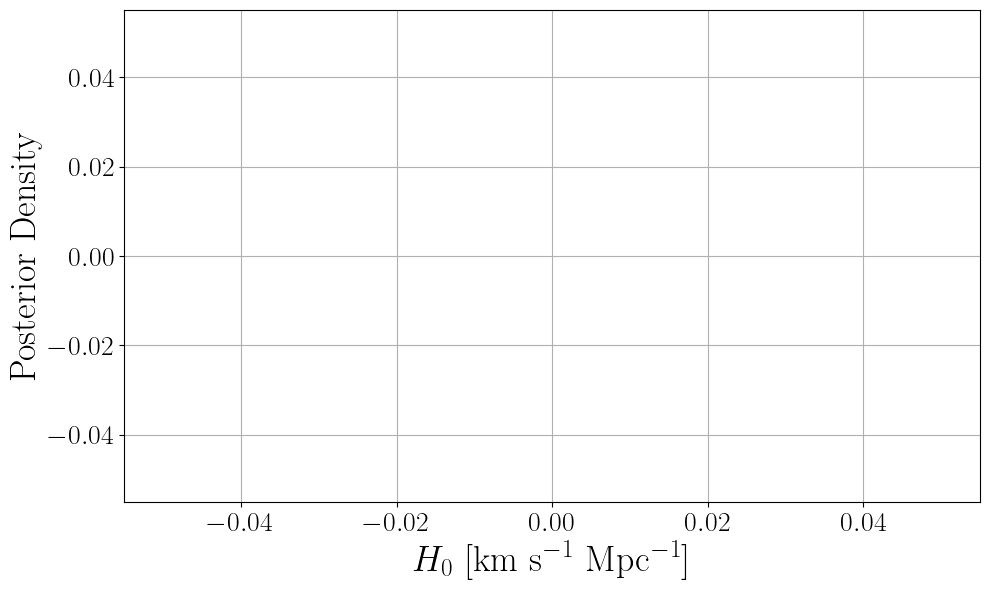

In [8]:
import healpy as hp
import numpy as np
import h5py, os
from scipy.interpolate import CubicSpline
from scipy.integrate import trapezoid
from tqdm import tqdm
import matplotlib.pyplot as plt
import pickle
from astropy.cosmology import FlatLambdaCDM, z_at_value, Planck18
import pandas as pd
import astropy.constants as const

from ligo.skymap.postprocess import crossmatch
from ligo.skymap.io import read_sky_map

###constants###
Mo = const.M_sun.value #solar mass [kg]
G = const.G.value #Newton constant [m^3 kg^-1 s^2]
c = const.c.value #light speed [m s^-1]
pc = const.pc.value #1pc [m]
###############

def z_from_dL(dL, H0, Om=omega_m):
    H0 = H0
    Om0 = Om
    cosmo = FlatLambdaCDM(H0=H0, Om0=Om0)
    if np.isscalar(dL):
         z = z_at_value(cosmo.luminosity_distance, dL * u.Mpc, zmin=0.0)
    else:
         z = np.array([z_at_value(cosmo.luminosity_distance, d_i * u.Mpc, zmin=0.0) for d_i in dL])
    return z

def E(z, _O_m=omega_m):
    cosmo = FlatLambdaCDM(H0=70, Om0=_O_m)
    return 1 / cosmo.efunc(z)

def comoving_distance(z_array, H0, n_points=10, O_m=omega_m):
    cosmo = FlatLambdaCDM(H0=H0, Om0=O_m)
    return cosmo.comoving_distance(z_array).value

def luminosity_distance(z, H0, n_points=10, O_m=omega_m):
    cosmo = FlatLambdaCDM(H0=H0, Om0=O_m)
    return cosmo.luminosity_distance(z).value

def create_cosmo_interpolator(H0):
    dl_table = luminosity_distance(z_table, H0, 1000)
    return CubicSpline(z_table, dl_table)

def gauss(x, m, s, n=1):
    return n*(s*np.sqrt(2*np.pi))**(-1)*np.exp(-0.5*((x-m)/s)**2)

def madau(z, gamma=4.59, k=2.86, zp=2.47):
    return (1+((1+zp)**(-gamma-k)))*((1+z)**(gamma-1))/(1+(((1+z)/(1+zp))**(gamma+k)))

def likelihood(z_array, H0, dl_interp, gal_z, gal_zsigma, gal_m, gal_p, gal_distmu, gal_distsig, gal_distnorm, chunk_size=1000):
    
    dl_array = dl_interp(z_array) # shape (N_z,)
    
    # p_rate = madau(z_array)
    p_rate = np.ones(len(z_array)) # Uniform in comoving volume and source-frame time
    
    integrand_array = (dl_array/(1+z_array))**2 * c*1e-3 / (H0*E(z_array)) # shape (N_z,)
    
    
    # lum_mask = gal_absmag<M_max+5*np.log10(H0/100)
    
    z_matrix = z_array[np.newaxis, :] # shape (1, N_z)
    dL_matrix = dl_array[np.newaxis, :] # shape (1, N_z)
    integrand_matrix = integrand_array[np.newaxis, :] # shape (1, N_z)

    total_likelihood = 0
    n_gal = len(gal_z)
    chunk_size = chunk_size
    for i in range(0, n_gal, chunk_size):
        end_i = min(i + chunk_size, n_gal)

        g_z = gal_z[i:end_i, np.newaxis]       # shape (N_chunk, 1)
        g_sig = gal_zsigma[i:end_i, np.newaxis] # shape (N_chunk, 1)
        g_mu = gal_distmu[i:end_i, np.newaxis] # shape (N_chunk, 1)
        g_dsig = gal_distsig[i:end_i, np.newaxis] # shape (N_chunk, 1)
        g_dnorm = gal_distnorm[i:end_i, np.newaxis] # shape (N_chunk, 1)
        g_p = gal_p[i:end_i, np.newaxis] # shape (N_chunk, 1)
        g_m = gal_m[i:end_i, np.newaxis] # shape (N_chunk, 1)
        
        g_absmag = g_m - 5*np.log10(dL_matrix*1e6) + 5 # shape (N_chunk, N_z), For high z, k corrections are needed here
        # gal_lum = 3.828e26*10**(-0.4*(gal_absmag)) # Luminosity weighting
        gal_lum = np.ones_like(g_absmag) # shape (N_chunk,), Uniform weighting

        p_em = gauss(z_matrix, g_z, g_sig) * p_rate * gal_lum # shape (N_chunk, N_z)
        p_gw = gauss(dL_matrix, g_mu, g_dsig, n=g_dnorm * g_p) # shape (N_chunk, N_z)

        evidence = np.trapz(p_em * integrand_matrix, z_array, axis=1) # (N_chunk,)
        numerator = np.trapz(p_em * p_gw * integrand_matrix, z_array, axis=1) # (N_chunk,)
        valid = evidence > 0
        total_likelihood += np.sum(numerator[valid] / evidence[valid])
    beta = H0**(3)
    return total_likelihood/beta

"""GW data"""
p, distnorm, distmu, distsig = hp.read_map(GW_sky_map_file_path, field=[0, 1, 2, 3]) # should be RING, not NEST
nside = hp.npix2nside(len(p))

"""set up H0 array and redshift array"""
h0_array_params = (20, 140, 100) # H0 grid for likelihood eval
h0_array = np.linspace(*h0_array_params)
z_array_max = z_from_dL(distmu[np.argmax(p)]+5*distsig[np.argmax(p)], H0=np.min(h0_array)) * 1.1
z_array = np.linspace(0.001, z_array_max, 4990)
print(f'redshift array: {z_array[0]} to {z_array[-1]}')

"""Create array of splines for luminosity distance"""
interp_file = './data/h0_interpolators_{}_{}_{}.pickle'.format(*h0_array_params)
if os.path.exists(interp_file):
    with open(interp_file, 'rb') as f:
        h0_interpolators = pickle.load(f)
else:
    h0_interpolators = []
    for i in tqdm(range(len(h0_array))):
        h0_interpolators.append(create_cosmo_interpolator(h0_array[i]))
    with open(interp_file, 'wb') as f:
        pickle.dump(h0_interpolators, f)

"""load galaxy catalog filtered by apparent magnitude in r band"""
galaxy_df = filtered_df.copy()
gal_ra = np.array(galaxy_df['ra_true'][:])
gal_dec = np.array(galaxy_df['dec_true'][:])
gal_mr = np.array(galaxy_df['mag_true_r_lsst_no_host_extinction'][:])
gal_true_z = np.array(galaxy_df['redshift_true'][:])
gal_measured_z = np.array(galaxy_df['redshift_measured'][:])
gal_z_sigma = np.abs(gal_true_z - gal_measured_z)
gal_z_sigma = np.maximum(gal_z_sigma, 0.01)

while np.any(gal_measured_z <= 0):
    mask = gal_measured_z <= 0
    gal_measured_z[mask] = np.random.normal(gal_true_z[mask], gal_z_sigma[mask])
    
"""make galaxy selections"""
### distance ###
print('calculating distance cut...')
percentile_80_for_gaussian = 1.28155
# percentale_90_for_gaussian = 1.64485
# percentile_95_for_gaussian = 1.95996
gal_dL_for_largest_H0 = luminosity_distance(gal_measured_z, H0=np.max(h0_array))
distance_mask = (gal_dL_for_largest_H0<distmu[np.argmax(p)]+percentile_80_for_gaussian*distsig[np.argmax(p)]) # in UPPER 90% credible interval

### sky position ###
print('calculating sky position cut...')
sorted_p = np.sort(p)[::-1]
cumsum_p = np.cumsum(sorted_p)
idx_90 = np.searchsorted(cumsum_p, 0.9)
prob_threshold_90 = sorted_p[idx_90]
gal_hpx_idx_all = hp.ang2pix(nside, gal_ra, gal_dec, lonlat=True, nest=False)
gal_p_all = p[gal_hpx_idx_all]
is_in_90Sky_mask = gal_p_all >= prob_threshold_90

full_mask = distance_mask & is_in_90Sky_mask

print(f"Number of galaxies after applying distance and sky position cuts: {np.sum(full_mask)} out of {len(galaxy_df)}")

masked_gal_ra = gal_ra[full_mask]
masked_gal_dec = gal_dec[full_mask]
masked_gal_true_z = gal_true_z[full_mask]
masked_gal_measured_z = gal_measured_z[full_mask]
masked_gal_z_sigma = gal_z_sigma[full_mask]
masked_gal_mr = gal_mr[full_mask]

gal_hpx_idx = hp.ang2pix(nside, masked_gal_ra, masked_gal_dec, lonlat=True, nest=False)
gal_p = p[gal_hpx_idx]
gal_distmu = distmu[gal_hpx_idx]
gal_distsig = distsig[gal_hpx_idx]
gal_distnorm = distnorm[gal_hpx_idx]

"""Evaluate H0 likelihood"""
likelihood_list = []
for i in tqdm(range(len(h0_array))):
    val = likelihood(
                    z_array,
                    h0_array[i],
                    h0_interpolators[i],
                    masked_gal_measured_z,
                    masked_gal_z_sigma,
                    masked_gal_mr,
                    gal_p,
                    gal_distmu,
                    gal_distsig,
                    gal_distnorm,
                    chunk_size=100
                        )
    likelihood_list.append(val)
print("Likelihood list:", likelihood_list)    
like = np.array(likelihood_list)
like /= np.trapz(like, h0_array)

plt.style.use('~/research/my_plot_style.style')
plt.figure()
plt.plot(h0_array, like, color='blue', lw=2)
plt.xlabel(r'$H_0$ [km s$^{-1}$ Mpc$^{-1}$]')
plt.ylabel('Posterior Density')
plt.grid(True)
plt.show()

redshift array: 0.001 to 0.01915252251178938
calculating distance cut...
calculating sky position cut...
Number of galaxies after applying distance and sky position cuts: 4871 out of 211882


100%|██████████| 100/100 [00:43<00:00,  2.32it/s]


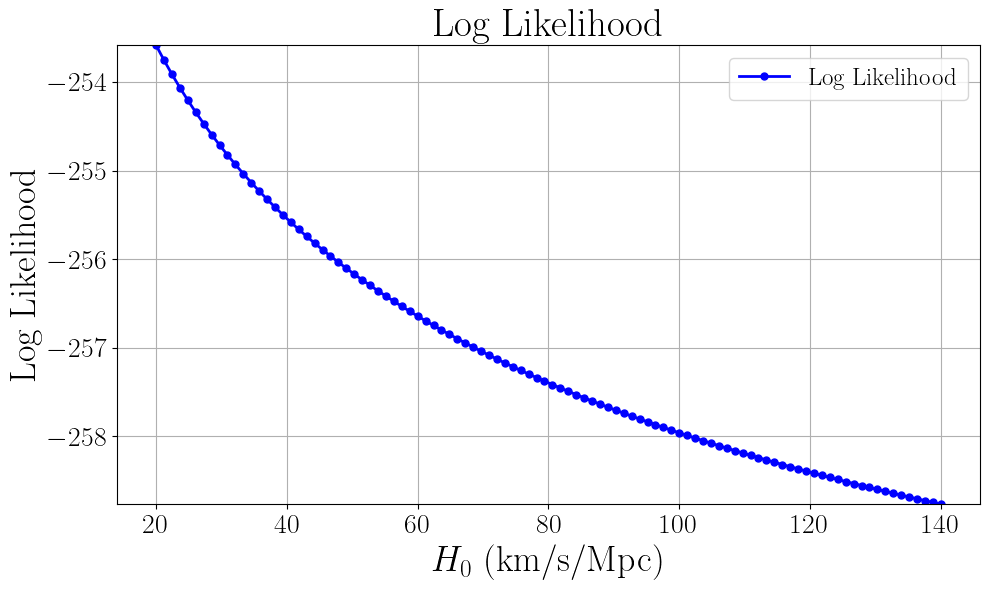

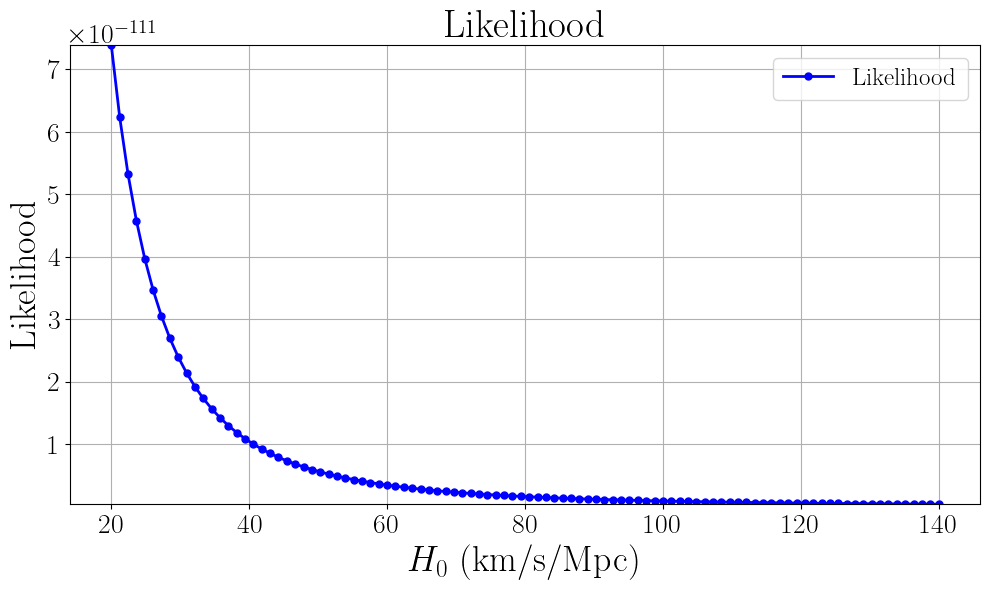

In [7]:
import healpy as hp
import numpy as np
import h5py, os
from scipy.interpolate import CubicSpline
from scipy.integrate import trapezoid
from tqdm import tqdm
import matplotlib.pyplot as plt
import pickle
from astropy.cosmology import FlatLambdaCDM, z_at_value, Planck18
import pandas as pd
import astropy.constants as const
import scipy.interpolate
from scipy.stats import norm
from scipy.special import logsumexp

from ligo.skymap.postprocess import crossmatch
from ligo.skymap.io import read_sky_map
from distancetool.find_horizon_range_network_de import calculate_range_from_distancetool # updated from original version for this calculation

###constants###
Mo = const.M_sun.value #solar mass [kg]
G = const.G.value #Newton constant [m^3 kg^-1 s^2]
c = const.c.value #light speed [m s^-1]
pc = const.pc.value #1pc [m]
###############

def H0_prior_transform(u):
    """
    Transforms the uniform random variable `u ~ Unif[0., 1.)`
    to the parameter of interest `x ~ Unif[20., 140.)`.
    """
    prior_max = 140.
    prior_min = 20.
    x = prior_min + u * (prior_max - prior_min)
    return x

def H_z(z, H0, is_plamck18=False):
    """
    Returns the Hubble parameter at redshift z by assuming cosmology.
    unit: km/s/Mpc
    """
    if is_plamck18:
        cosmo = Planck18
    else:
        H0 = H0
        Om0 = 0.3
        cosmo = FlatLambdaCDM(H0=H0, Om0=Om0)
    return cosmo.H(z).value

def comoving_distance(z, H0, is_plamck18=False):
    """
    Returns the comoving distance at redshift z by assuming cosmology.
    unit: Mpc
    """
    if is_plamck18:
        cosmo = Planck18
    else:
        H0 = H0
        Om0 = 0.3
        cosmo = FlatLambdaCDM(H0=H0, Om0=Om0)
    return cosmo.comoving_distance(z).value

def p_delta_z(delta_z, mu=0.0, sigma=1e-5):
    """
    Here mean and sigma of \Delta z set to be -0.002.
    Returns the probability density function for the redshift
    using a Gaussian distribution with mean `mu` and standard deviation `sigma`.
    """
    return (1 / np.sqrt(2 * np.pi * sigma**2)) * np.exp(-0.5 * ((delta_z - mu) / sigma) ** 2)

def p_dGW_given_dL_Omega(z, H0, prob, distmu, distnorm, diststd, is_plamck18=False):
    """
    Returns the probability density function for the gravitational wave distance
    given the luminosity distance and Omega.
    """
    # dL = comoving_distance(z, H0) * (1 + z) # Luminosity distance in Mpc
    if is_plamck18:
        cosmo = Planck18
    else:
        H0 = H0
        Om0 = 0.3
        cosmo = FlatLambdaCDM(H0=H0, Om0=Om0)
    dL = cosmo.luminosity_distance(z).value # Luminosity distance in Mpc
    p = distnorm * prob * norm(distmu, diststd).pdf(dL)
    return p

def create_V_dL_max_GW_interpolated(H0_array):
    """
    Using distancetool to calculate the maximum volume.
    unit: Mpc^3
    """
    m1 = 30.0  # Solar masses
    m2 = 30.0  # Solar masses
    network = ['H','L','V']
    asdfile_list = [os.path.join(os.path.expanduser("~"),"Development/distancetool/data/aligo_O3actual_H1.txt"),
                    os.path.join(os.path.expanduser("~"),"Development/distancetool/data/aligo_O3actual_L1.txt"),
                    os.path.join(os.path.expanduser("~"),"Development/distancetool/data/avirgo_O3actual.txt")
                   ]
    pwfile = 'o3_120_60_hlv_bbh_30_30_imrD'
    omega_m = 0.3
    omega_de = 0.7
    omega_k = 0

    volume_array = []
    for H0 in tqdm(H0_array):
        H0 = H0
        result = calculate_range_from_distancetool(m1, m2, network, asdfile_list, pwfile, omega_m, omega_de, omega_k, H0=H0)
        max_range = result[0]
        volume_array.append((4/3) * np.pi * (max_range**3))
    return scipy.interpolate.CubicSpline(H0_array, volume_array)
    
def V_dL_GW_max(H0, approx=False):
    """
    Using distancetool to calculate the maximum volume.
    unit: Mpc^3
    """
    if not approx:
        m1 = 30.0  # Solar masses
        m2 = 30.0  # Solar masses
        network = ['H','L','V']
        asdfile_list = [os.path.join(os.path.expanduser("~"),"Development/distancetool/data/aligo_O3actual_H1.txt"),
                        os.path.join(os.path.expanduser("~"),"Development/distancetool/data/aligo_O3actual_L1.txt"),
                        os.path.join(os.path.expanduser("~"),"Development/distancetool/data/avirgo_O3actual.txt")
                       ]
        pwfile = 'o3_120_60_hlv_bbh_30_30_imrD'
        omega_m = 0.3
        omega_de = 0.7
        omega_k = 0

        H0 = H0
        result = calculate_range_from_distancetool(m1, m2, network, asdfile_list, pwfile, omega_m, omega_de, omega_k, H0=H0)
        max_range = result[0]

        volume = (4/3) * np.pi * (max_range**3)
    else:
        volume = H0**(3)
    return volume

def p_dEM_z_delta_z(z, z_mu, z_sigma, delta_z):
    return (1 / np.sqrt(2 * np.pi * z_sigma**2)) * np.exp(-0.5 * ((z - z_mu - delta_z) / z_sigma) ** 2)

def sample_z_dz(z_max, z_min, delta_z_max, delta_z_min, N_z=1000, N_dz=500):
    z_samples = np.linspace(z_min, z_max, N_z)
    dz_samples = np.linspace(delta_z_min, delta_z_max, N_dz)
    Z, DZ = np.meshgrid(z_samples, dz_samples, indexing='ij') # (2, N) array, along axis 0: z, axis 1: delta_z change
    return Z, DZ

def luminosity_distance(z, H0, is_plamck18=False):
    """
    Returns the comoving distance at redshift z
    using the Planck18 cosmology.
    unit: Mpc
    """
    if is_plamck18:
        cosmo = Planck18
    else:
        H0 = H0
        Om0 = 0.3
        cosmo = FlatLambdaCDM(H0=H0, Om0=Om0)
    return cosmo.luminosity_distance(z).value

def calculate_abs_mag(z, m, H0, is_plamck18=False):
    # dL = comoving_distance(z, H0=H0) * (1 + z)  # Luminosity distance in Mpc
    if is_plamck18:
        cosmo = Planck18
    else:
        H0 = H0
        Om0 = 0.3
        cosmo = FlatLambdaCDM(H0=H0, Om0=Om0)
    dL = cosmo.luminosity_distance(z).value # Luminosity distance in Mpc
    return m - 5 * (np.log10(dL*10**6) - 1)

def z_from_dL(dL, H0, Om=omega_m):
    H0 = H0
    Om0 = Om
    cosmo = FlatLambdaCDM(H0=H0, Om0=Om0)
    if np.isscalar(dL):
         z = z_at_value(cosmo.luminosity_distance, dL * u.Mpc, zmin=0.0)
    else:
         z = np.array([z_at_value(cosmo.luminosity_distance, d_i * u.Mpc, zmin=0.0) for d_i in dL])
    return z

def loglike(x, gal_df, GW_df, V_dL_GW_max_interpolated, z_samples, dz_samples, consider_H0_cubic=True, V_max_approx=False):
    H0 = x[0]
    epsilon = 1e-100  # avoid log(0) term

    """set up of using data"""
    gal_pixel_indices_array = gal_df['pixel_indices'].values
    gal_measured_redshift_array = gal_df['redshift_measured'].values
    gal_redshift_sigma_array = gal_df['redshift_sigma'].values
    
    """GW data"""
    GW_prob_array = GW_df['PROBDENSITY'].values
    GW_distmu_array = GW_df['DISTMU'].values
    GW_distsigma_array = GW_df['DISTSIGMA'].values
    GW_distnorm_array = GW_df['DISTNORM'].values
    GW_pixel_indices = GW_df.index.values

    """z, dz sample"""
    z_sample_array, delta_z_sample_array = z_samples, dz_samples
    z_samples_1d = z_sample_array[:, 0]
    dz_samples_1d = delta_z_sample_array[0, :]
    log_z_step = np.log(z_samples_1d[1] - z_samples_1d[0])
    log_dz_step = np.log(dz_samples_1d[1] - dz_samples_1d[0])

    """p(dz)"""
    p_dz_array = p_delta_z(dz_samples_1d, mu=-0.002, sigma=0.002)
    log_p_dz_array = np.log(p_dz_array + epsilon)  # Avoid log(0)
    
    """r(z) Mpc"""
    r_array = comoving_distance(z_samples_1d, H0=H0)
    log_r_array = np.log(r_array + epsilon)  # Avoid log(0)

    """H(z) km/s/Mpc"""
    Hz_array = H_z(z_samples_1d, H0=H0)
    log_Hz_array = np.log(Hz_array + epsilon)  # Avoid log(0)

    """r^2*c/H Mpc^3"""
    log_jac_array = 2*log_r_array - log_Hz_array + np.log(c) - np.log(10**3)  # log(r^2*c/H)

    log_L_contributions_list = []
    num_of_gal_once = 1500
    N_gals = len(gal_df)
    for start_index in range(0, N_gals, num_of_gal_once):
        end_index = min(start_index + num_of_gal_once, N_gals)

        """Gather GW data for all relevant galaxies at once using their pixel indices"""
        gw_prob_gals = GW_prob_array[gal_pixel_indices_array[start_index:end_index]]
        gw_distmu_gals = GW_distmu_array[gal_pixel_indices_array[start_index:end_index]]
        gw_distnorm_gals = GW_distnorm_array[gal_pixel_indices_array[start_index:end_index]]
        gw_distsigma_gals = GW_distsigma_array[gal_pixel_indices_array[start_index:end_index]]

        gw_prob_gals_reshaped = gw_prob_gals[:, np.newaxis] #shape (num_galaxies, 1)
        gw_distmu_gals_reshaped = gw_distmu_gals[:, np.newaxis] #shape (num_galaxies, 1)
        gw_distnorm_gals_reshaped = gw_distnorm_gals[:, np.newaxis] #shape (num_galaxies, 1)
        gw_distsigma_gals_reshaped = gw_distsigma_gals[:, np.newaxis] #shape (num_galaxies, 1)

        """reshape of galaxy redshifts"""
        z_mean_gals_reshaped = gal_measured_redshift_array[start_index:end_index, np.newaxis, np.newaxis]
        z_sigma_gals_reshaped = gal_redshift_sigma_array[start_index:end_index, np.newaxis, np.newaxis]

        # Calculate probabilities for chunk of galaxies
        # The output of these functions will be 2D or 3D arrays, with the first dimension
        # corresponding to the galaxies. Shape: (num_galaxies, N_samples) or (num_galaxies, N_z_samples, N_dz_samples)

        """p(dGW | dL, Omega) for all galaxies"""
        # Resulting shape: (num_galaxies, N_z_samples)
        log_p_gw_array_all = np.log(p_dGW_given_dL_Omega(
                                    z_samples_1d,
                                    H0,
                                    gw_prob_gals_reshaped,
                                    gw_distmu_gals_reshaped,
                                    gw_distnorm_gals_reshaped,
                                    gw_distsigma_gals_reshaped
                                    ) + epsilon
                                    )

        """p(dEM | z, dz) for all galaxies"""
        # resulting shape: (num_galaxies, N_z_samples, N_dz_samples)
        log_p_z_dz_array_all = np.log(p_dEM_z_delta_z(
                                        z_sample_array,
                                        z_mean_gals_reshaped,
                                        z_sigma_gals_reshaped,
                                        delta_z_sample_array
                                        ) + epsilon
                                        )

        """Marginalize over dz for all galaxies"""
        # axis=2 corresponds to the delta_z dimension
        # integrand shape: (num_galaxies, N_z_samples, N_dz_samples)
        # resulting shape: (num_galaxies, N_z_samples)
        log_integrand_dz = log_p_z_dz_array_all + log_p_dz_array
        log_p_dEM_marginalized_all = logsumexp(log_integrand_dz, axis=2) + log_dz_step

        """ Calculate the numerator of the likelihood for all galaxies"""
        # axis=1 corresponds to the z dimension
        # integrand shape: (num_galaxies, N_z_samples)
        # resulting shape: (num_galaxies)
        log_integrand_z_numerator = log_p_gw_array_all + log_p_dEM_marginalized_all + log_jac_array
        log_integral_numerator_all = logsumexp(log_integrand_z_numerator, axis=1) + log_z_step

        """Calculate the denominator (evidence term Z_i) for all galaxies"""
        # integrand shape: (num_galaxies, N_z_samples)
        # resulting shape: (num_galaxies)
        log_p_z_0_array_all = np.log(p_dEM_z_delta_z(
                                        z_samples_1d,
                                        gal_measured_redshift_array[start_index:end_index, np.newaxis],
                                        gal_redshift_sigma_array[start_index:end_index, np.newaxis],
                                        0.0
                                        ) + epsilon
                                        )
        log_integrand_z_denominator = log_p_z_0_array_all + log_jac_array
        log_integral_denominator_Zi_all = logsumexp(log_integrand_z_denominator, axis=1) + log_z_step

        """Calculate log likelihood contribution for each galaxy"""
        log_L_contributions = log_integral_numerator_all - log_integral_denominator_Zi_all
        log_L_contributions_list.append(logsumexp(log_L_contributions))

    log_total_L = logsumexp(np.array(log_L_contributions_list))
    if not V_max_approx:
        if consider_H0_cubic:
            # V_GW = V_dL_GW_max(H0) * H0**3
            beta = V_dL_GW_max_interpolated(H0) * H0**3
        else:
            beta = V_dL_GW_max_interpolated(H0)
    else:
        beta = H0**3
    log_V_GW = np.log(beta + epsilon)  # Avoid log(0)
    logL = log_total_L - log_V_GW
    return logL

"""GW data"""
p, distnorm, distmu, distsig = hp.read_map(GW_sky_map_file_path, field=[0, 1, 2, 3]) # should be RING, not NEST
nside = hp.npix2nside(len(p))

GW_df = pd.DataFrame({
    'PROBDENSITY': p,
    'DISTMU': distmu,
    'DISTSIGMA': distsig,
    'DISTNORM': distnorm
})

"""set up H0 array and redshift array"""
h0_array_params = (20, 140, 100) # H0 grid for likelihood eval
h0_array = np.linspace(*h0_array_params)
z_array_max = z_from_dL(distmu[np.argmax(p)]+5*distsig[np.argmax(p)], H0=np.min(h0_array)) * 1.1
z_array = np.linspace(0.001, z_array_max, 4990)
print(f'redshift array: {z_array[0]} to {z_array[-1]}')

"""load galaxy catalog filtered by apparent magnitude in r band"""
galaxy_df = filtered_df.copy()
gal_ra = np.array(galaxy_df['ra_true'][:])
gal_dec = np.array(galaxy_df['dec_true'][:])
gal_mr = np.array(galaxy_df['mag_true_r_lsst_no_host_extinction'][:])
gal_true_z = np.array(galaxy_df['redshift_true'][:])
gal_measured_z = np.array(galaxy_df['redshift_measured'][:])
gal_z_sigma = np.abs(gal_true_z - gal_measured_z)
gal_z_sigma = np.maximum(gal_z_sigma, 0.01)
while np.any(gal_measured_z <= 0):
    mask = gal_measured_z <= 0
    gal_measured_z[mask] = np.random.normal(gal_true_z[mask], gal_z_sigma[mask])

"""make galaxy selections"""
### distance ###
print('calculating distance cut...')
percentile_80_for_gaussian = 1.28155
# percentale_90_for_gaussian = 1.64485
# percentile_95_for_gaussian = 1.95996
gal_dL_for_largest_H0 = luminosity_distance(gal_measured_z, H0=np.max(h0_array))
distance_mask = (gal_dL_for_largest_H0<distmu[np.argmax(p)]+percentile_80_for_gaussian*distsig[np.argmax(p)]) # in UPPER 90% credible interval

### sky position ###
print('calculating sky position cut...')
sorted_p = np.sort(p)[::-1]
cumsum_p = np.cumsum(sorted_p)
idx_90 = np.searchsorted(cumsum_p, 0.9)
prob_threshold_90 = sorted_p[idx_90]
gal_hpx_idx_all = hp.ang2pix(nside, gal_ra, gal_dec, lonlat=True, nest=False)
gal_p_all = p[gal_hpx_idx_all]
is_in_90Sky_mask = gal_p_all >= prob_threshold_90

full_mask = distance_mask & is_in_90Sky_mask

print(f"Number of galaxies after applying distance and sky position cuts: {np.sum(full_mask)} out of {len(galaxy_df)}")

masked_gal_ra = gal_ra[full_mask]
masked_gal_dec = gal_dec[full_mask]
masked_gal_true_z = gal_true_z[full_mask]
masked_gal_measured_z = gal_measured_z[full_mask]
masked_gal_z_sigma = gal_z_sigma[full_mask]
masked_gal_mr = gal_mr[full_mask]

gal_hpx_idx = hp.ang2pix(nside, masked_gal_ra, masked_gal_dec, lonlat=True, nest=False)
gal_p = p[gal_hpx_idx]
gal_distmu = distmu[gal_hpx_idx]
gal_distsig = distsig[gal_hpx_idx]
gal_distnorm = distnorm[gal_hpx_idx]

gal_df = pd.DataFrame({
    'redshift_measured': masked_gal_measured_z,
    'redshift_sigma': masked_gal_z_sigma,
    'pixel_indices': hp.ang2pix(nside, masked_gal_ra, masked_gal_dec, lonlat=True, nest=False)
})

"""z and dz samples"""
N_samples_z = int(1e2)  # Number of samples for z
N_samples_dz = int(5*1e1)  # Number of samples for dz
z_range = (0, 0.2)  # Redshift range
delta_z_range = (-0.005, 0.001)  # Delta z range
z_sample_array, delta_z_sample_array = sample_z_dz(z_range[1], z_range[0], delta_z_range[1], delta_z_range[0], N_z=N_samples_z, N_dz=N_samples_dz)

"""H0 grid and interpolators"""
h0_array_params = (20, 140, 100) # H0 grid for likelihood eval
h0_array = np.linspace(*h0_array_params)

"""Create array of splines for V_dL_GW_max if not exist"""
interp_file = './data/V_dL_max_GW_interpolated_{}_{}_{}.pickle'.format(*h0_array_params)
if os.path.exists(interp_file):
    with open(interp_file, 'rb') as f:
        V_dL_GW_max_interpolated = pickle.load(f)
else:
    print('Creating V_dL_GW_max_interpolated...')
    V_dL_GW_max_interpolated = create_V_dL_max_GW_interpolated(h0_array)
    with open(interp_file, 'wb') as f:
        pickle.dump(V_dL_GW_max_interpolated, f)

"""calculate for multiple H0 values"""
log_likelihood_list = []

for H0_value in tqdm(h0_array):
    log_likelihood = loglike(x=[H0_value], gal_df=gal_df, GW_df=GW_df, V_dL_GW_max_interpolated=V_dL_GW_max_interpolated, z_samples=z_sample_array, dz_samples=delta_z_sample_array, consider_H0_cubic=True, V_max_approx=False)
    # print(f'H0: {H0_value:.2f} km/s/Mpc')
    # print(f"logL: {log_likelihood:.4f}")
    # print("-" * 20)
    # print('')
    log_likelihood_list.append(log_likelihood)
likelihood_list = np.exp(log_likelihood_list)

plt.style.use('~/research/my_plot_style.style')
"""plot for multiple H0 values"""
plt.figure()
plt.plot(h0_array, log_likelihood_list, label='Log Likelihood', color='blue', marker='o', markersize=5, linestyle='-')
plt.xlabel(r'$H_0$ (km/s/Mpc)')
plt.ylabel('Log Likelihood')
plt.title('Log Likelihood')
plt.ylim(np.min(log_likelihood_list), np.max(log_likelihood_list)) 
plt.legend()
plt.grid(True)
plt.show()

plt.figure()
plt.plot(h0_array, likelihood_list, label='Likelihood', color='blue', marker='o', markersize=5, linestyle='-')
plt.xlabel(r'$H_0$ (km/s/Mpc)')
plt.ylabel('Likelihood')
plt.title('Likelihood')
plt.ylim(np.min(likelihood_list), np.max(likelihood_list)) 
plt.legend()
plt.grid(True)
plt.show()